# I/O model

making sense out of data and metadata

## retrieve data from s3 bucket

In [1]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
!mkdir -p data
files = [
    "pythia/radar/erad2024/baltrad/baltrad_short_course/201405190715_SUR.h5",
]
for file in files:
    name = os.path.join("data", Path(file).name)
    if not os.path.exists(name):
        print(f"downloading, {name}")
        urllib.request.urlretrieve(f"{URL}{file}", name)

downloading, data/201405190715_SUR.h5


## Import the file I/O module along with the main RAVE module containing useful constants

In [2]:
%matplotlib inline
import _raveio, _rave

## Read an input ODIM_H5 file

In [3]:
rio = _raveio.open("data/201405190715_SUR.h5")

## What is the payload in the I/O container?

In [4]:
rio.objectType is _rave.Rave_ObjectType_PVOL

True

## How many scans does this volume contain?

In [5]:
pvol = rio.object
print("%i scans in polar volume" % pvol.getNumberOfScans())

8 scans in polar volume


## Ascending or descending scan strategy?

In [6]:
pvol.isAscendingScans()

True

## Where is this site?

### Note that all angles are represented internally in radians

In [7]:
from Proj import rd

print(
    "Site is located at %2.3f° lon, %2.3f° lat and %3.1f masl"
    % (pvol.longitude * rd, pvol.latitude * rd, pvol.height)
)
print("Site's ODIM source identifiers are: %s" % pvol.source)

Site is located at 25.519° lon, 58.482° lat and 157.0 masl
Site's ODIM source identifiers are: WMO:26232,RAD:EE41,PLC:SÃ¼rgavere,NOD:eesur


## Access lowest scan and query some characteristics

In [8]:
scan = pvol.getScan(0)
nrays, nbins = scan.nrays, scan.nbins
print("Elevation angle %2.1f°" % (scan.elangle * rd))
print("%i rays per sweep" % nrays)
print("%i bins per ray" % nbins)
print("%3.1f meter range bins" % scan.rscale)
print("First ray scanned is ray %i (indexing starts at 0)" % scan.a1gate)
print("Data acquisition started on %s:%sZ" % (scan.startdate, scan.starttime))
print("Data acquisition ended on %s:%sZ" % (scan.enddate, scan.endtime))
print(
    "Scan contains %i quantities: %s"
    % (len(scan.getParameterNames()), scan.getParameterNames())
)

Elevation angle 0.5°
360 rays per sweep
831 bins per ray
300.0 meter range bins
First ray scanned is ray 189 (indexing starts at 0)
Data acquisition started on 20140519:071509Z
Data acquisition ended on 20140519:071537Z
Scan contains 10 quantities: ['DBZH', 'RHOHV', 'HCLASS', 'WRADH', 'PHIDP', 'ZDR', 'SQIH', 'KDP', 'VRADH', 'TH']


## Access horizontal reflectivity and query some characteristics

In [9]:
dbzh = scan.getParameter("DBZH")
print("Quantity is %s" % dbzh.quantity)
print("8-bit unsigned byte data? %s" % str(dbzh.datatype is _rave.RaveDataType_UCHAR))
print(
    "Linear scaling coefficients from 0-255 to dBZ: gain=%2.1f, offset=%2.1f"
    % (dbzh.gain, dbzh.offset)
)
print(
    "Unradiated areas = %2.1f, radiated areas with no echo = %2.1f"
    % (dbzh.nodata, dbzh.undetect)
)

dbzh_data = dbzh.getData()  # Accesses the NumPy array containing the reflectivities
print(
    "NumPy array's dimensions = %s and type = %s"
    % (str(dbzh_data.shape), dbzh_data.dtype)
)

Quantity is DBZH
8-bit unsigned byte data? True
Linear scaling coefficients from 0-255 to dBZ: gain=0.5, offset=-32.0
Unradiated areas = 255.0, radiated areas with no echo = 0.0
NumPy array's dimensions = (360, 831) and type = uint8


## A primitive visualizer for plotting B-scans

In [10]:
# Convenience functionality. First convert a palette from GoogleMapsPlugin for use with matplotlib
import matplotlib
from GmapColorMap import dbzh as pal

colorlist = []
for i in range(0, len(pal), 3):
    colorlist.append([pal[i] / 255.0, pal[i + 1] / 255.0, pal[i + 2] / 255.0])

# Then create a simple plotter
import matplotlib.pyplot as plt


def plot(data):
    fig = plt.figure(figsize=(16, 12))
    plt.title("B-scan")
    plt.imshow(data, cmap=matplotlib.colors.ListedColormap(colorlist), clim=(0, 255))
    plt.colorbar(shrink=float(nrays) / nbins)

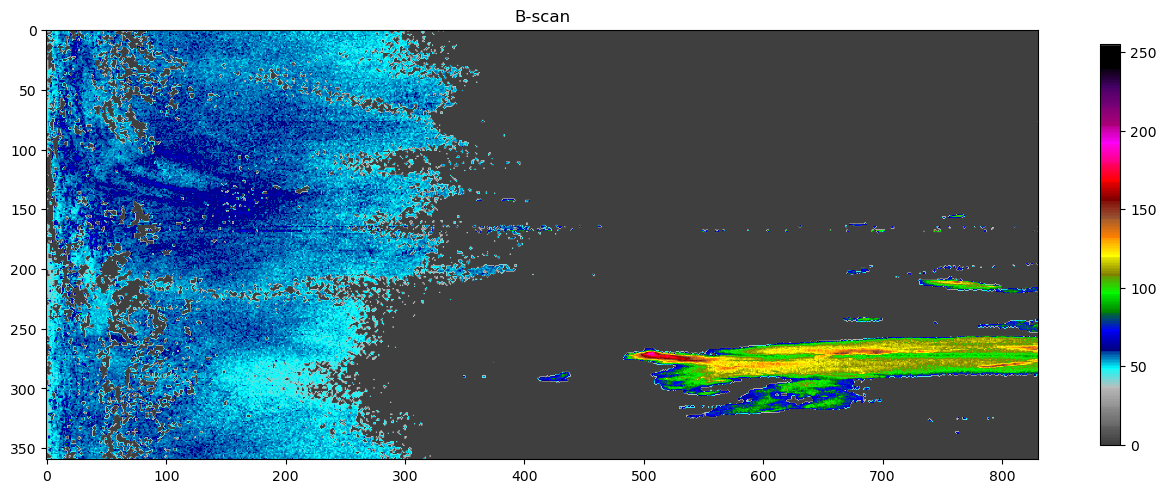

In [11]:
plot(dbzh_data)

## Management of optional metadata

### While manadatory metadata are represented as object attributes in Python, optional metadata are not!

In [12]:
print("Polar volume has %i optional attributes" % len(pvol.getAttributeNames()))
print("Polar scan has %i optional attributes" % len(scan.getAttributeNames()))
print(
    "Quantity %s has %i optional attributes"
    % (dbzh.quantity, len(dbzh.getAttributeNames()))
)

print("Mandatory attribute: beamwidth is %2.1f°" % (pvol.beamwidth * rd))
print(
    "Optional attributes: Radar is a %s running %s"
    % (pvol.getAttribute("how/system"), pvol.getAttribute("how/software"))
)

Polar volume has 14 optional attributes
Polar scan has 36 optional attributes
Quantity DBZH has 3 optional attributes
Mandatory attribute: beamwidth is 1.0°
Optional attributes: Radar is a VAISWRM200 running IRIS


### Add a bogus attribute

In [13]:
dbzh.addAttribute("how/foo", "bar")
print(
    "Quantity %s now has %i optional attributes"
    % (dbzh.quantity, len(dbzh.getAttributeNames()))
)

Quantity DBZH now has 4 optional attributes


## Create an empty parameter and populate it

In [14]:
import _polarscanparam

param = _polarscanparam.new()
param.quantity = "DBZH"
param.nodata, param.undetect = 255.0, 0.0
param.gain, param.offset = 0.4, -30.0

import numpy

data = numpy.zeros((420, 500), numpy.uint8)
param.setData(data)

## Create an empty scan and add the parameter to it

In [15]:
import _polarscan
from Proj import dr

newscan = _polarscan.new()
newscan.elangle = 25.0 * dr
newscan.addAttribute("how/simulated", "True")

newscan.addParameter(param)
print("%i rays per sweep" % newscan.nrays)
print("%i bins per ray" % newscan.nbins)

420 rays per sweep
500 bins per ray


### See how the parameter's dimensions were passed along to the scan, so they don't have to be set explicitly. Nevertheless, plenty of metadata must be handled explicitly or ODIM_H5 files risk being incomplete.

In [16]:
newscan.a1gate = 0
newscan.beamwidth = 1.0 * dr
newscan.rscale = 500.0
newscan.rstart = (
    0.0  # Distance in meters to the start of the first range bin, unknown=0.0
)
newscan.startdate = "20140831"
newscan.starttime = "145005"
newscan.enddate = "20140831"
newscan.endtime = "145020"

# Top-level attributes
newscan.date = "20140831"
newscan.time = "145000"
newscan.source = "WMO:26232,RAD:EE41,PLC:Sürgavere,NOD:eesur"
newscan.longitude = 25.519 * dr
newscan.latitude = 58.482 * dr
newscan.height = 157.0

## Now create a new I/O container and write the scan to ODIM_H5 file.

In [17]:
container = _raveio.new()
container.object = newscan
container.save("data/myscan.h5")

import os

print("ODIM_H5 file is %i bytes large" % os.path.getsize("data/myscan.h5"))

ODIM_H5 file is 4721 bytes large


### Remove compression. It makes file I/O faster. You can also tune HDF5 file-creation properties through the I/O container object.

In [18]:
container.compression_level = 0  # ZLIB compression levels 0-9
container.save("data/myscan.h5")
print("ODIM_H5 file is now %i bytes large" % os.path.getsize("data/myscan.h5"))

ODIM_H5 file is now 214320 bytes large
